# Sentiment Analysis Prediction

## Table of Contents:
* [0. Problem Description](#Problem)
* [1. Exploratory Data Analysis (EDA)](#EDA)
* [2. Feature Engineering](#Feat)
  * [2.1. Correlation](#Corr)
  * [2.2. NZV](#NZV)
  * [2.3. Split Train & Test](#Split)
  * [2.4. RFE](#RFE)
  * [2.5. Standardization & PCA](#PCA)  
* [3. Predictions](#Pred)

# <a class="anchor" id="Problem"> 0. Problem Description </a>

The idea behind this project is to scrap the web to extract pages containing previously chosen words related to sentiment or feeling about a certain phone, so that we could provide an answer of the type ‘brand X is preferred among people at this moment’.

An NGO called Common Crawl, collects all the internet’s webpages (billions) created each month, once a month. I used this service to download last month’s data (only the data that matched our conditions).

In [1]:
# Libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import plotly.express as px

# PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing

# RFE & MODELLING
from sklearn.preprocessing import MinMaxScaler #Standardization
from sklearn.feature_selection import VarianceThreshold #NZV
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Cross Validation
from sklearn.model_selection import train_test_split
from math import sqrt

In [2]:
# Load Datasets
random.seed(203)
import os
os.getcwd()
os.chdir('/home/s/Desktop/Dropbox/Documents/Python/Mod4 Ubiqum/Datasets')

galaxy = pd.read_csv('galaxy_smallmatrix_labeled_9d.csv')
iphone = pd.read_csv('iphone_smallmatrix_labeled_8d.csv')

iphone["iphonesentiment"] = iphone["iphonesentiment"].replace(0,1)
iphone["iphonesentiment"] = iphone["iphonesentiment"].replace(5,4)

# <a class="anchor" id="EDA"> 1. Exploratory Data Analysis </a>

In [3]:
print(galaxy.shape)
print(iphone.shape)

(12911, 59)
(12973, 59)


In [4]:
iphone.head()

,iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,sonycampos,...,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc,iphonesentiment
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
print(sum(iphone.iloc[:,0])) #iPhone:  28525
print(sum(iphone.iloc[:,1])) #SGalaxy: 921
print(sum(iphone.iloc[:,2])) #SXperia: 311
print(sum(iphone.iloc[:,3])) #NokiaAlumina: 30
print(sum(iphone.iloc[:,4])) #HTCphone: 1775

27867
923
312
30
1779


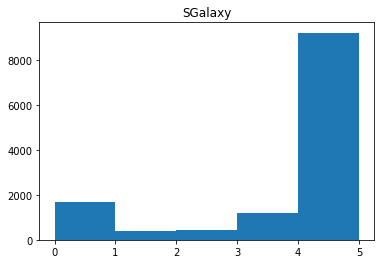

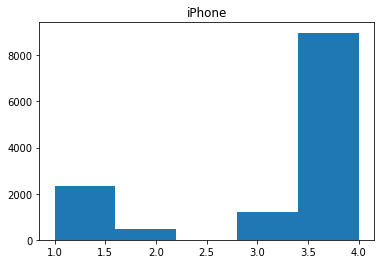

In [6]:
plt.hist(galaxy['galaxysentiment'], bins=5)
plt.title('SGalaxy')
plt.show()
plt.hist(iphone['iphonesentiment'], bins=5)
plt.title('iPhone')
plt.show()

# <a class="anchor" id="Feat"> 2. Feature Engineering </a>

## <a class="anchor" id="Corr"> 2.1. Correlation </a>

In [7]:
# Collinear columns WITHOUT any relationship to the dependant variable
def find_correlation(df, thresh=0.9):
   corrMatrix = iphone.corr()
   corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)
   already_in = set()
   result = []
   for col in corrMatrix:
       perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
       if perfect_corr and col not in already_in:
           already_in.update(set(perfect_corr))
           perfect_corr.append(col)
           result.append(perfect_corr)
   select_nested = [f[1:] for f in result]
   select_flat = [i for j in select_nested for i in j]
   return select_flat

print(find_correlation(iphone, thresh=0.9))

#Dropping collinear columns between themselves (from 59 to 44!)
iphone = iphone.drop(columns=find_correlation(iphone, thresh=0.9))
print(iphone.shape)

['iphone', 'htcphone', 'nokiacamunc', 'nokiadisneg', 'nokiacampos', 'samsungdispos', 'nokiadispos', 'samsungdisneg', 'nokiadisunc', 'nokiaperunc', 'nokiaperpos', 'iosperunc', 'iosperpos', 'googleperpos']
(12973, 45)


In [8]:
# Correlation with the dependant
corr = iphone.corr()

cor_target = abs(corr["iphonesentiment"]) # Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.3]

print(relevant_features)

samsunggalaxy      0.341222
iphonesentiment    1.000000
Name: iphonesentiment, dtype: float64


## <a class="anchor" id="NZV"> 2.2. NZV </a>

In [9]:
# Remove columns with Near Zero Variance (NZV)
# NOTE: This loses the column names
constant_filter = VarianceThreshold(threshold=0.01) #For Zero Variance, choose 0
constant_filter.fit(iphone)

iphone.columns[constant_filter.get_support()]
constant_columns = [column for column in iphone.columns
                   if column not in iphone.columns[constant_filter.get_support()]]

iphone = constant_filter.transform(iphone) #This overwrites our data with the NZV columns removed
iphone = pd.DataFrame(iphone)

print(iphone.shape) #This leaves us with 40 columns (from 44, after collinearity)

(12973, 41)


## <a class="anchor" id="Split"> 2.3. Split Train & Test </a>

In [10]:
#Defining Train & Label
x = iphone.iloc[:,:-1] #Good practice to select all columns but the last one
y = iphone.iloc[:,-1] #Good practice to get the last column

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10378, 40), (2595, 40), (10378,), (2595,))

## <a class="anchor" id="RFE"> 2.4. RFE </a>

In [11]:
RF = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0)
rfe = RFE(estimator=RF, step=3)
rfe = rfe.fit(x_train, y_train)
## print summaries for the selection of attributes
selected_rfe = pd.DataFrame({'Feature': list(x_train.columns),'Ranking': rfe.ranking_})

print(selected_rfe.sort_values(by='Ranking'))
x_train = rfe.transform(x_train)
x_test = rfe.transform(x_test)

    Feature  Ranking
0         0        1
25       25        1
24       24        1
29       29        1
21       21        1
20       20        1
33       33        1
18       18        1
17       17        1
34       34        1
15       15        1
26       26        1
28       28        1
11       11        1
8         8        1
7         7        1
4         4        1
3         3        1
2         2        1
1         1        1
14       14        2
36       36        2
37       37        3
12       12        3
13       13        3
35       35        4
5         5        4
22       22        4
39       39        5
38       38        5
27       27        5
30       30        6
32       32        6
6         6        6
23       23        7
16       16        7
9         9        7
31       31        8
10       10        8
19       19        8


## <a class="anchor" id="PCA"> 2.5. Standardization & PCA </a>

In [12]:
stand = MinMaxScaler().fit(x_train)
x_train = stand.transform(x_train)
pca = PCA(0.999)
pca.fit(x_train)
x_train = pd.DataFrame(pca.transform(x_train))
#Test
x_test = stand.transform(x_test)
x_test = pd.DataFrame(pca.transform(x_test))

# <a class="anchor" id="Pred"> 3. Predictions </a>

In [13]:
#RANDOM FOREST
RF = RandomForestClassifier(n_estimators =100).fit(x_train,y_train)
#print(cross_val_score(RF_B, x_train, y_train['galaxysentiment'], cv=10))

#Predictions
RF_pred = RF.predict(x_test)

#Performance Metrics (Errors)
print("Accuracy:", accuracy_score(y_test, RF_pred)) 
print("Kappa:", cohen_kappa_score(y_test, RF_pred)) 
print(classification_report(y_test, RF_pred))
confusion_matrix(y_test, RF_pred)

#Acc=0.74 w/o PCA & RFE
#Kappa=0.48 w/o PCA & RFE
#Acc=0.73 w
#Kappa=.45 w

Accuracy: 0.8046242774566474
Kappa: 0.49324546838005634
              precision    recall  f1-score   support

           1       0.77      0.38      0.51       445
           2       0.33      0.01      0.03        73
           3       0.65      0.58      0.61       232
           4       0.82      0.97      0.89      1845

    accuracy                           0.80      2595
   macro avg       0.64      0.49      0.51      2595
weighted avg       0.79      0.80      0.78      2595



array([[ 171,    1,   45,  228],
       [   1,    1,    8,   63],
       [   8,    0,  134,   90],
       [  42,    1,   20, 1782]])